# Ingest Tabular Data

When ingesting structured data from an existing S3 bucket into a SageMaker Notebook, there are multiple ways to handle it. We will introduce the following methods to access your data from the notebook:

* Copying your data to your instance. If you are dealing with a normal size of data or are simply experimenting, you can copy the files into the SageMaker instance and just use it as a file system in your local machine. 
* Using Python packages to directly access your data without copying it. One downside of copying your data to your instance is: if you are done with your notebook instance and delete it, all the data is gone with it unless you store it elsewhere. We will introduce several methods to solve this problem in this notebook, and using python packages is one of them. Also, if you have large data sets (for example, with millions of rows), you can directly read data from S3 utilizing S3 compatible python libraries with built-in functions.
* Using AWS native methods to directly access your data. You can also use AWS native packages like `s3fs` and `aws data wrangler` to access your data directly.  

We will demonstrate how to ingest the following tabular (structured) into a notebook for further analysis:
## Tabular data: Boston Housing Data
The [Boston House](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) contains  information collected by the U.S Census Service concerning housing in the area of Boston Mass. We will use the data set to showcase how to ingest tabular data into S3, and for further pre-processing and feature engineering. The dataset contains the following columns (506 rows):
* `CRIM` - per capita crime rate by town
* `ZN` - proportion of residential land zoned for lots over 25,000 sq.ft.
* `INDUS` - proportion of non-retail business acres per town.
* `CHAS` - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* `NOX` - nitric oxides concentration (parts per 10 million)
* `RM` - average number of rooms per dwelling
* `AGE` - proportion of owner-occupied units built prior to 1940
* `DIS` - weighted distances to five Boston employment centres
* `RAD` - index of accessibility to radial highways
* `TAX` - full-value property-tax rate per \$10,000
* `PTRATIO` - pupil-teacher ratio by town
* `B` - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* `LSTAT` - \% lower status of the population

### Download data from online resources and write data to S3

In [26]:
%pip install -qU 'sagemaker>=2.15.0' 's3fs==0.4.2' 'awswrangler==1.2.0'
# you would need s3fs version > 0.4.0 for aws data wrangler to work correctly

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [27]:
import awswrangler as wr
import pandas as pd
import s3fs
import sagemaker



In [28]:
data_s3_location = "s3://vmip-evaluation-boston-housing/test.csv"  # S3 URL
s3_tabular_data = pd.read_csv(data_s3_location)
s3_tabular_data

PermissionError: Forbidden

In [4]:

bucket = sagemaker_session.default_bucket()  # replace with your own bucket name if you have one
# bucket = "s3://vmip-evaluation-boston-housing/test.csv"

data_wr_location = bucket
print(data_wr_location)
data_wr_location = "s3://{}/{}/{}".format(bucket, prefix, filename)  # S3 URL
# wr_data = wr.s3.read_csv(path=data_wr_location, nrows=5)
wr_data = wr.s3.read_csv(path=data_wr_location)
wr_data.head()
# prefix = "data/tabular/boston_house"
# filename = "boston_house.csv"

NameError: name 'sagemaker_session' is not defined

In [ ]:
# helper functions to upload data to s3
def write_to_s3(filename, bucket, prefix):
    # put one file in a separate folder. This is helpful if you read and prepare data with Athena
    filename_key = filename.split(".")[0]
    key = "{}/{}/{}".format(prefix, filename_key, filename)
    s3.Bucket(bucket).upload_file(filename, key)
    size = get_size(bucket, key)
    return size


def upload_to_s3(bucket, prefix, filename):
    url = "s3://{}/{}/{}".format(bucket, prefix, filename)
    print("Writing to {}".format(url))
    size = write_to_s3(filename, bucket, prefix)
#     print(size, "bytes")
#     print(size/1000, "kB")
    print(size/1000000, "MB")
    print(size/1000000000, "GB")
    

import boto3
def get_size(bucket_name, file_path):
    client = boto3.client(service_name='s3', use_ssl=True)
    response = client.head_object(
        Bucket=bucket_name,
        Key=file_path
    )
    return response['ContentLength']
    

In [ ]:
# download files from tabular data source location
tabular_data = load_boston()
tabular_data_full = pd.DataFrame(tabular_data.data, columns=tabular_data.feature_names)
tabular_data_full["target"] = pd.DataFrame(tabular_data.target)

# for i in range(20):
#     tabular_data_full = tabular_data_full.append(tabular_data_full, ignore_index = True)

# tabular_data_full.to_csv("boston_house.csv", index=False)
print(tabular_data_full.head())

In [ ]:
upload_to_s3(bucket, "data/tabular", filename)

### AWS Data Wrangler
[AWS Data Wrangler](https://github.com/awslabs/aws-data-wrangler) is an open-source Python library that extends the power of the Pandas library to AWS connecting DataFrames and AWS data related services (Amazon Redshift, AWS Glue, Amazon Athena, Amazon EMR, Amazon QuickSight, etc), which we will cover in later sections. It is built on top of other open-source projects like Pandas, Apache Arrow, Boto3, s3fs, SQLAlchemy, Psycopg2 and PyMySQL, and offers abstracted functions to execute usual ETL tasks like load/unload data from Data Lakes, Data Warehouses and Databases. Note that you would need `s3fs version > 0.4.0` for the `awswrangler csv reader` to work.

In [39]:

print("s3://{}/{}/{}".format(bucket, prefix, filename))

data_wr_location = "s3://vmip-evaluation-boston-housing/test.csv"
print(data_wr_location)
# data_wr_location = "s3://{}/{}/{}".format(bucket, prefix, filename)  # S3 URL
# wr_data = wr.s3.read_csv(path=data_wr_location, nrows=5)
wr_data = wr.s3.read_csv(path=data_wr_location)
wr_data.head()

s3://sagemaker-eu-west-2-551521621776/data/tabular/boston_house/boston_house.csv
s3://vmip-evaluation-boston-housing/test.csv


ClientError: An error occurred (AccessDenied) when calling the ListObjectsV2 operation: Access Denied

### Data Exploration

<AxesSubplot:xlabel='NOX', ylabel='target'>

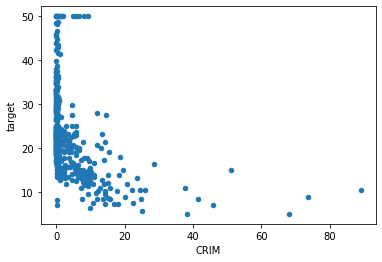

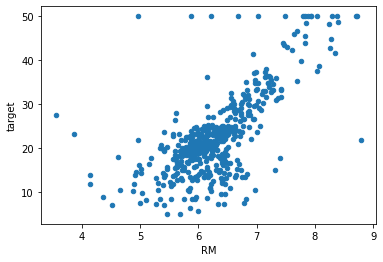

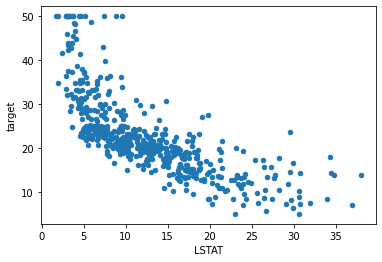

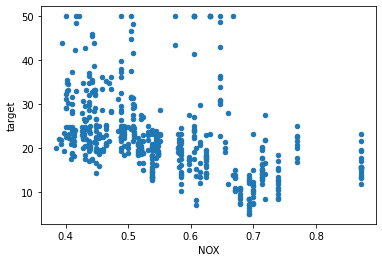

In [35]:
#Data exploration
train_dataset = wr_data
train_dataset.plot(kind="scatter", x="CRIM", y="target")
train_dataset.plot(kind="scatter", x="RM", y="target")
train_dataset.plot(kind="scatter", x="LSTAT", y="target")
train_dataset.plot(kind="scatter", x="NOX", y="target")

### Train Dataset

#### Split dataset

In [9]:
df_train = train_dataset

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=42, shuffle=True)


y_train = df_train["target"].to_numpy()
X_train = df_train.drop(columns=["target"])
y_test = df_test["target"].to_numpy()
X_test = df_test.drop(columns=["target"])

print(y_train, X_train, y_test, X_test)

[36.2 34.7 24.  33.4]       CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
4     18.7  396.90   5.33  
2     17.8  392.83   4.03  
0     15.3  396.90   4.98  
3     18.7  394.63   2.94   [21.6]       CRIM   ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  PTRATIO  \
1  0.02731  0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0     17.8   

       B  LSTAT  
1  396.9   9.14  


### Train

In [10]:
pip install lightgbm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import lightgbm as lgb

#Prepare model

gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)



[1]	valid_0's l1: 42.55	valid_0's l2: 1810.5
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 42.55	valid_0's l2: 1810.5
[3]	valid_0's l1: 42.55	valid_0's l2: 1810.5
[4]	valid_0's l1: 42.55	valid_0's l2: 1810.5
[5]	valid_0's l1: 42.55	valid_0's l2: 1810.5
[6]	valid_0's l1: 42.55	valid_0's l2: 1810.5
Early stopping, best iteration is:
[1]	valid_0's l1: 42.55	valid_0's l2: 1810.5


LGBMRegressor(learning_rate=0.05, n_estimators=20)

### Prediction

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print(len(y_pred))
print(len(y_test))
# eval
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

r_squared = r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average')

print(r_squared)

Starting predicting...
1
1
The RMSE of prediction is: 10.475000762939452
nan


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


### Citation
Boston Housing data,  Harrison, D. and Rubinfeld, D.L. `Hedonic prices and the demand for clean air', J. Environ. Economics & Management, vol.5, 81-102, 1978.